# Project 1 in Machine Learning, Kernel-trick

**Author:** Antoine Cornaz, Zeineb Mellouli, Anas Himmi
**Date:** 1.11.2024

## 1. Introduction

### 1.1 Problem Statement
This machine learning project consists of two main phases. The dataset used contains medical records of patients, both healthy and those diagnosed with cardiovascular disease (CVD). The first phase focuses on implementing the functions covered in class and exercise sessions. The second phase aims to optimize the model for the best possible prediction, simulating a real-world scenario.

### 1.2 Objective

The objective of this project is to develop a machine learning model capable of predicting the presence of cardiovascular disease (CVD) in patients based on their medical information. The performance of the model will be evaluated using the following metrics:
- **Accuracy**: To measure the overall correctness of the model's predictions.
- **F1-Score**: To assess the balance between precision and recall, particularly for the CVD class.
- **Precision**: To evaluate the proportion of true positive predictions among all positive predictions.
- **Recall**: To measure the proportion of true positive predictions among all actual positive instances.

The goal is to optimize the model to achieve the best possible performance on these metrics, but most importantly on the F1-score, simulating real-world predictive scenarios.

### 1.3 Dataset Description
The dataset consists of records from 328,135 patients, each described by 321 dimensions containing various medical information. While none of the patients have all 321 medical fields fully populated, 92 key medical attributes are consistently available for every patient. The data originates from the **Behavioral Risk Factor Surveillance System (BRFSS)**, a health-related telephone survey system that gathers state-level data on U.S. residents. The BRFSS focuses on health-related risk behaviors, chronic health conditions, and the usage of preventive health services. This dataset provides a rich source of information for analyzing cardiovascular disease (CVD) and related health factors.

The description and definition of each feature can be found in the following link : https://www.cdc.gov/brfss/annual_data/2015/pdf/codebook15_llcp.pdf. We can observe that most features are categorical which will lead us to make all of them categorical, and use algorithms that can handle categorical data or use encoding techniques to convert them to numerical data (e.g., one-hot encoding).

## 2. Data Loading and Exploration

## 2.1 Import and Initialisation

In [1]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

from implementations import *


# %load_ext autoreload
# %autoreload 2

In [2]:
x_train = np.genfromtxt("data/x_train.csv", delimiter=",", skip_header=1)
features = np.genfromtxt("data/x_train.csv", delimiter=",", dtype=str, max_rows=1)
y_train = np.genfromtxt("data/y_train.csv", delimiter=",", skip_header=1)
y_features = np.genfromtxt("data/y_train.csv", delimiter=",", dtype=str, max_rows=1)

In [3]:
x_test = np.genfromtxt("data/x_test.csv",delimiter=",", skip_header=1)

## 2.2 Data Preprocessing

In [4]:
def to_categorical(array, range_min, range_max, n_bins):
    """
    Converts a numerical array into categorical bins based on specified range and number of bins.
    Parameters:
    array (numpy.ndarray): The input array containing numerical values.
    range_min (float): The minimum value of the range to consider for binning.
    range_max (float): The maximum value of the range to consider for binning.
    n_bins (int): The number of bins to divide the range into.
    Returns:
    function: A function that takes a value and returns the corresponding bin index or the value itself if it is outside the specified range.
              If the value is NaN, it returns -1.
    Notes:
    - Values outside the specified range are returned as is.
    - NaN values are assigned a bin index of -1.
    - Bin edges are calculated using quantiles to ensure approximately equal distribution of values across bins.
    - The rightmost bin includes values exactly equal to range_max.
    """
    # Filter array to include only values within the specified range
    filtered_values = array[(array >= range_min) & (array <= range_max)]
    
    # Calculate the bin edges using quantiles
    bin_edges = np.quantile(filtered_values, np.linspace(0, 1, n_bins + 1))
    
    def assign_bin(value):
        # Check if the value is NaN
        if np.isnan(value):
            return -1
        
        # If the value is outside the range, return it as is
        if value < range_min or value > range_max:
            return value
        
        # Assign bin based on which range the value falls into
        # We use right=True to ensure that values exactly equal to range_max are included in the last bin
        return np.digitize(value, bin_edges, right=True)
    
    return assign_bin



# a dictionary that maps the column names to the corresponding mapping function
# - For naturally categorical, we map the NaN values to -1
# - For numerical, we check the codebook for all possible values 
#   and map the range of numerical values to a range of bins (e.g. 0-30 to 4 bins) 
#   then map the rest to their own category (don't know, didn't want to answer, Nan etc.)
# We only keep vaguely relevant columns to our problem. We will further refine this list later.

mapping_dict = {
    "GENHLTH": lambda value: value if not np.isnan(value) else -1,
    "PHYSHLTH": to_categorical(array=x_train[:, features=="PHYSHLTH"].flatten(), range_min=0, range_max=30, n_bins=4),
    "MENTHLTH": to_categorical(array=x_train[:, features=="MENTHLTH"].flatten(), range_min=0, range_max=30, n_bins=4),
    "POORHLTH": to_categorical(array=x_train[:, features=="POORHLTH"].flatten(), range_min=0, range_max=30, n_bins=4),
    "HLTHPLN1": lambda value: value if not np.isnan(value) else -1,
    "MEDCOST": lambda value: value if not np.isnan(value) else -1,
    "CHECKUP1": lambda value: value if not np.isnan(value) else -1,
    "BPHIGH4": lambda value: value if not np.isnan(value) else -1,
    "BPMEDS": lambda value: value if not np.isnan(value) else -1,
    "BLOODCHO": lambda value: value if not np.isnan(value) else -1,
    "CHOLCHK": lambda value: value if not np.isnan(value) else -1,
    # "CVDINFR4": lambda value: 1 if value == 1 else 0,
    # "CVDCRHD4": lambda value: 1 if value == 1 else 0,
    "TOLDHI2": lambda value: value if not np.isnan(value) else -1,
    "CVDSTRK3": lambda value: value if not np.isnan(value) else -1,
    "ASTHMA3": lambda value: value if not np.isnan(value) else -1,
    "ASTHNOW": lambda value: value if not np.isnan(value) else -1,
    "CHCSCNCR": lambda value: value if not np.isnan(value) else -1,
    "CHCOCNCR": lambda value: value if not np.isnan(value) else -1,
    "CHCCOPD1": lambda value: value if not np.isnan(value) else -1,
    "HAVARTH3": lambda value: value if not np.isnan(value) else -1,
    "ADDEPEV2": lambda value: value if not np.isnan(value) else -1,
    "CHCKIDNY": lambda value: value if not np.isnan(value) else -1,
    "DIABETE3": lambda value: value if not np.isnan(value) else -1,
    "SEX": lambda value: value if not np.isnan(value) else -1,
    "MARITAL": lambda value: value if not np.isnan(value) else -1,
    "EDUCA": lambda value: value if not np.isnan(value) else -1,
    "VETERAN3": lambda value: value if not np.isnan(value) else -1,
    "INCOME2": lambda value: value if not np.isnan(value) else -1,
    "INTERNET": lambda value : value if not np.isnan(value) else -1,
    "WTKG3": to_categorical(array=x_train[:, features=="WTKG3"].flatten(), range_min=23, range_max=295, n_bins=6),
    "QLACTLM2": lambda value : value if not np.isnan(value) else -1,
    "USEEQUIP": lambda value : value if not np.isnan(value) else -1,
    "BLIND": lambda value : value if not np.isnan(value) else -1,
    "DECIDE": lambda value : value if not np.isnan(value) else -1,
    "DIFFWALK": lambda value : value if not np.isnan(value) else -1,
    "DIFFDRES": lambda value : value if not np.isnan(value) else -1,
    "DIFFALON": lambda value : value if not np.isnan(value) else -1,
    "SMOKE100": lambda value : value if not np.isnan(value) else -1,
    "SMOKDAY2": lambda value : value if not np.isnan(value) else -1,
    "LASTSMK2": lambda value : value if not np.isnan(value) else -1,
    "USENOW3": lambda value : value if not np.isnan(value) else -1,
    "AVEDRNK2": to_categorical(array=x_train[:, features=="AVEDRNK2"].flatten(), range_min=1, range_max=76, n_bins=5),
    "DRNK3GE5": to_categorical(array=x_train[:, features=="DRNK3GE5"].flatten(), range_min=1, range_max=76, n_bins=5),
    "EXERANY2": lambda value : value if not np.isnan(value) else -1,
    # "EXERHMM1": lambda value: str(value//200) if value <= 959 and value not in [777,999] else -1,
    "LMTJOIN3": lambda value : value if not np.isnan(value) else -1,
    "FLUSHOT6": lambda value : value if not np.isnan(value) else -1,
    "PDIABTST": lambda value : value if not np.isnan(value) else -1,
    "PREDIAB1": lambda value : value if not np.isnan(value) else -1,
    "INSULIN": lambda value : value if not np.isnan(value) else -1,
    "CIMEMLOS": lambda value : value if not np.isnan(value) else -1,
    "_RFHLTH": lambda value : value if not np.isnan(value) else -1,
    "_HCVU651": lambda value : value if not np.isnan(value) else -1,
    "_RFHYPE5": lambda value : value if not np.isnan(value) else -1,
    "_CHOLCHK": lambda value : value if not np.isnan(value) else -1,
    "_RFCHOL": lambda value : value if not np.isnan(value) else -1,
    # "_MICHD": lambda value: value if value <= 2 else -1,
    "_LTASTH1": lambda value : value if not np.isnan(value) else -1,
    "_CASTHM1": lambda value : value if not np.isnan(value) else -1,
    "_DRDXAR1": lambda value : value if not np.isnan(value) else -1,
    "_AGEG5YR": lambda value : value if not np.isnan(value) else -1,
    "_AGE_G": lambda value : value if not np.isnan(value) else -1,
    "HTM4": to_categorical(array=x_train[:, features=="HTM4"].flatten(), range_min=0.91, range_max=2.44, n_bins=6),
    "_RFBMI5": lambda value : value if not np.isnan(value) else -1,
    "_EDUCAG": lambda value : value if not np.isnan(value) else -1,
    "_SMOKER3": lambda value : value if not np.isnan(value) else -1,
    "_RFBING5": lambda value : value if not np.isnan(value) else -1,
    "_BMI5CAT": lambda value : value if not np.isnan(value) else -1,
    "_RFDRHV5": lambda value : value if not np.isnan(value) else -1,
    "FTJUDA1_": to_categorical(array=x_train[:, features=="FTJUDA1_"].flatten(), range_min=0, range_max=99.99, n_bins=4),
    "MAXVO2_": to_categorical(array=x_train[:, features=="MAXVO2_"].flatten(), range_min=0, range_max=50.1, n_bins=6),
    "ACTIN11_": lambda value : value if not np.isnan(value) else -1,
    "ACTIN21_": lambda value : value if not np.isnan(value) else -1,
    "_PACAT1": lambda value : value if not np.isnan(value) else -1,
    "_PA150R2": lambda value : value if not np.isnan(value) else -1,
    "_PA300R2": lambda value : value if not np.isnan(value) else -1,
    "_PASTRNG":  lambda value : value if not np.isnan(value) else -1,
    "_PASTAE1": lambda value : value if not np.isnan(value) else -1,
    "_LMTACT1": lambda value : value if not np.isnan(value) else -1,
    "_LMTWRK1": lambda value : value if not np.isnan(value) else -1,
    "_LMTSCL1": lambda value : value if not np.isnan(value) else -1,
    "_INCOMG": lambda value : value if not np.isnan(value) else -1,
}

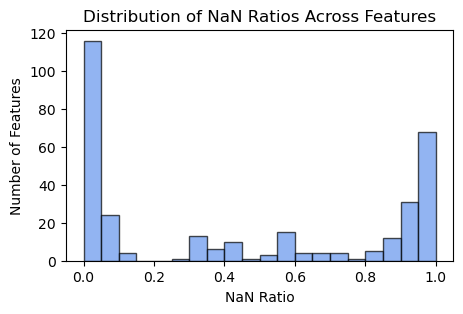

In [5]:
def analyze_missing_value_distribution_with_plot(x_train, features):
    """
    Analyzes the distribution of missing values (NaN ratios) for each feature in the dataset
    and visualizes the results with a histogram.

    Args:
        x_train (np.ndarray): A 2D numpy array of shape (n_samples, n_features) representing the training data.
        features (list of str): A list of feature names
    Returns:
        None. The function displays a histogram showing the distribution of NaN ratios across features.
    """
    nan_ratios = []

    # Calculate NaN ratio for each feature
    for idx in range(len(features)):
        nan_count = np.sum(np.isnan(x_train[:, idx]))
        nan_ratio = nan_count / x_train.shape[0]
        nan_ratios.append(nan_ratio)
    
    nan_ratios = np.array(nan_ratios)

    # Plotting the distribution of NaN ratios
    plt.figure(figsize=(5, 3))

    # Histogram to visualize the distribution
    plt.hist(nan_ratios, bins=20, edgecolor='k',color='cornflowerblue', alpha=0.7)
    plt.xlabel('NaN Ratio')
    plt.ylabel('Number of Features')
    plt.title('Distribution of NaN Ratios Across Features')
    plt.show()

analyze_missing_value_distribution_with_plot(x_train, features)

In [6]:
# Not necessary because we will do a greedy approach later (unless we want to save time)
def select_features_with_low_nan_ratio(X, features_to_check, threshold=0.1):
    """
    Select features from the training data that have a NaN ratio below a specified threshold.

    Parameters:
    X (numpy.ndarray): The feature data array.
    features_to_check (list): List of features to check for NaN ratios.
    threshold (float): The maximum allowable NaN ratio for a feature to be selected. Default is 0.1.

    Returns:
    list: A list of features that have a NaN ratio below the specified threshold.
    """
    nan_ratios = {}
    for feature in features_to_check:
        nan_ratios[feature] = np.sum(np.isnan(X[:, features == feature])) / len(X)

    selected_features = [feature for feature in nan_ratios if nan_ratios[feature] < threshold]
    
    return selected_features

# This is the function that applies the mapping to the selected features
def apply_mapping(X, selected_features, mapping_dict):
    """
    Applies a mapping function to selected features in the training data.

    Parameters:
    X (numpy.ndarray): The feature data array of shape (n_samples, n_features).
    selected_features (list): A list of feature indices to which the mapping functions will be applied (they need to be keys of mapping_dict)
    mapping_dict (dict): A dictionary where keys are feature indices and values are functions that map feature values.

    Returns:
    numpy.ndarray: A new array with the same number of samples as X but only the selected features, 
                   with the mapping functions applied to each feature.
    """
    X_filtered = np.zeros((X.shape[0], len(selected_features)))
    for feature in selected_features:
        feature_values = X[:, features == feature].flatten()
        if feature_values.size > 0:
            X_filtered[:, selected_features.index(feature)] = np.array([mapping_dict[feature](value) for value in feature_values])
    return X_filtered

Let's visualize the distribution of the target variable

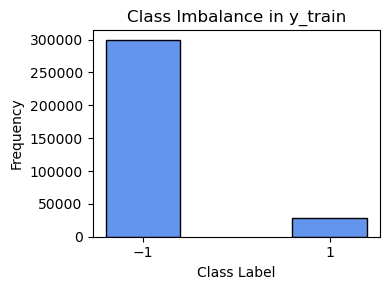

In [7]:
# only loading the specific column (index 1) to speed up the visualization
y_train_for_visualization = np.genfromtxt("data/y_train.csv", delimiter=",", skip_header=1, usecols=1) 
unique_classes, counts = np.unique(y_train_for_visualization, return_counts=True)
plt.figure(figsize=(4, 3))
plt.bar(unique_classes, counts, edgecolor='k',color='cornflowerblue')
plt.xticks(unique_classes)
plt.xlabel('Class Label')
plt.ylabel('Frequency')
plt.title('Class Imbalance in y_train')
plt.tight_layout()
plt.show()

We can observe that the target variable is imbalanced, with a higher number of healthy patients compared to those diagnosed with CVD. This imbalance can affect the model's performance, particularly in terms of recall and F1-score. Therefore, we will address this issue by oversampling the minority class by duplicating randomly selected instances from the CVD class.

In [8]:
# Proportion of Y=1 in the training set vs Y=-1
number_of_ones = np.sum(y_train == 1)
number_of_minus_ones = np.sum(y_train == -1)
total = len(y_train)
print(f"Proportion of Y=1: {number_of_ones/total*100:.2f}%")

Proportion of Y=1: 8.83%


In [7]:
def fix_class_imbalance(X, y, target_value=1, dont_balance=False):
    """
    Fix class imbalance by oversampling the minority class or undersampling the majority class.
    
    Parameters:
    X (numpy.ndarray): Feature matrix of shape (n_samples, n_features)
    y (numpy.ndarray): Target vector of shape (n_samples,), containing values -1 and 1
    target_value (int): Class value to balance to (default is 1)
    dont_balance (bool): If True, the function will not balance the classes (default is False)
    
    Returns:
    X_balanced (numpy.ndarray): Feature matrix with balanced classes
    y_balanced (numpy.ndarray): Balanced target vector
    """
    if dont_balance:
        return X, y

    # Separate samples by class
    class_1_indices = np.where(y == target_value)[0]
    class_minus_1_indices = np.where(y != target_value)[0]
    
    # Find class counts
    class_1_count = len(class_1_indices)
    class_minus_1_count = len(class_minus_1_indices)
    
    if class_1_count == class_minus_1_count:
        # If classes are already balanced, return the original data
        return X, y
    
    elif class_1_count < class_minus_1_count:
        # If class 1 is the minority, oversample class 1
        oversample_size = class_minus_1_count - class_1_count
        oversampled_indices = np.random.choice(class_1_indices, oversample_size, replace=True)
        new_indices = np.concatenate([np.arange(len(y)), oversampled_indices])
    else:
        # If class -1 is the minority, oversample class -1
        oversample_size = class_1_count - class_minus_1_count
        oversampled_indices = np.random.choice(class_minus_1_indices, oversample_size, replace=True)
        new_indices = np.concatenate([np.arange(len(y)), oversampled_indices])
    
    # Create the balanced dataset
    X_balanced = X[new_indices]
    y_balanced = y[new_indices]
    
    return X_balanced, y_balanced

We will implement here a LabelEncoder to simplify the design of algorithms and a OneHotEncoder to convert the categorical features into numerical data.

In [8]:
def one_hot_encode(X, selected_features):
    """
    One-hot encodes the selected features in the input matrix X.

    Parameters:
    X (ndarray): The input feature matrix of shape (n_samples, n_features).
    selected_features (list): A list of selected feature indices for one-hot encoding.

    Returns:
    ndarray: A matrix containing the one-hot encoded columns.
    """
    # Initialize a list to collect the one-hot encoded columns
    one_hot_encoded_list = []

    # Iterate over the final selected features
    for i, feature in enumerate(selected_features):
        # Extract feature values for the current feature
        feature_values = X[:, i]
        
        # Get unique values for this feature
        unique_values = np.unique(feature_values)
        
        # One-hot encode by creating a column for each unique value and append to the list
        one_hot_encoded_columns = [(feature_values == value).astype(int).reshape(-1, 1) for value in unique_values]
        one_hot_encoded_list.extend(one_hot_encoded_columns)
    
    # Concatenate all one-hot encoded columns horizontally
    X_OHE = np.hstack(one_hot_encoded_list)
    
    return X_OHE

def label_encode(X, selected_features):
    """
    Label encodes the selected features in the input matrix X.

    Parameters:
    X (ndarray): The input feature matrix of shape (n_samples, n_features).
    selected_features (list): A list of selected feature indices for label encoding.

    Returns:
    ndarray: A matrix containing the label encoded columns.
    """
    # Initialize a list to collect the label encoded columns
    label_encoded_list = []

    # Iterate over the final selected features
    for i, feature in enumerate(selected_features):
        # Extract feature values for the current feature
        feature_values = X[:, i]
        
        # Get unique values for this feature
        unique_values = np.unique(feature_values)
        
        # Label encode by mapping each unique value to an integer from 0 to n_categories - 1
        label_encoded_column = np.array([np.where(unique_values == value)[0][0] for value in feature_values]).reshape(-1, 1)
        label_encoded_list.append(label_encoded_column)
    
    # Concatenate all label encoded columns horizontally
    X_LE = np.hstack(label_encoded_list)
    
    return X_LE

We also will map the target variable to 0 and 1, where 0 represents healthy patients and 1 represents patients diagnosed with CVD because the logistic regression algorithm requires it.

In [9]:
def map_y_to_0_1(y):
    """
    Maps the target values from -1 and 1 to 0 and 1.

    Parameters:
    y (ndarray): The target vector containing values -1 and 1.

    Returns:
    ndarray: The target vector with values 0 and 1.
    """
    return (y + 1) // 2

def map_y_to_minus_1_1(y):
    """
    Maps the target values from 0 and 1 to -1 and 1.

    Parameters:
    y (ndarray): The target vector containing values 0 and 1.

    Returns:
    ndarray: The target vector with values -1 and 1.
    """
    return 2 * y - 1

## 2.3 Feature Importance

### 2.3.1 Normalized Mutual Information

We calculate the normalized mutual information between each feature and the target variable to identify the most relevant features for predicting CVD. This information will guide us in selecting the most important features for training the model.

In [57]:
import numpy as np

def calculate_feature_entropies(x_train_filtered, y_train, selected_features):
    """"
    Calculate entropy, joint entropy, mutual information, and normalized mutual information for each feature.
    """
    # Function to calculate entropy
    def calculate_entropy(probabilities):
        # Calculate entropy: H(X) = -sum(p(x) * log2(p(x)))
        assert np.isclose(np.sum(probabilities), 1), f"Probabilities do not sum to 1: {np.sum(probabilities)}"
        return -np.sum([p * np.log2(p) for p in probabilities if p > 0])

    entropies = []
    entropies_normalized = []
    joint_entropies = []
    joint_entropies_normalized = []
    mutual_informations = []
    NMI = []

    # Filter the rows based on target values
    Y1 = x_train_filtered[y_train[:, 1] == 1]
    Y_minus1 = x_train_filtered[y_train[:, 1] == -1]

    # Total counts for probabilities
    count_Y1 = len(Y1)
    count_Y_minus1 = len(Y_minus1)
    total_count = count_Y1 + count_Y_minus1

    # Calculate probabilities of Y
    p_Y1 = count_Y1 / total_count
    p_Y_minus1 = count_Y_minus1 / total_count

    # Entropy of Y
    entropy_Y = calculate_entropy([p_Y1, p_Y_minus1])

    # Iterate over the indices of the features
    for feature in selected_features:
        feature_index = selected_features.index(feature)
        # Get the feature values for the entire dataset (to find all unique values)
        all_feature_values = x_train_filtered[:, feature_index]
        unique_values_all, counts_all = np.unique(all_feature_values, return_counts=True)

        # Get the feature values for the filtered rows where Y=1
        feature_values_Y1 = Y1[:, feature_index]
        non_nan_values_Y1 = feature_values_Y1[~np.isnan(feature_values_Y1)]

        # Get the counts for each unique value in filtered rows where Y=1
        unique_values_filtered_Y1, counts_filtered_Y1 = np.unique(non_nan_values_Y1, return_counts=True)

        # Create a dictionary for filtered counts where Y=1
        filtered_count_dict_Y1 = dict(zip(unique_values_filtered_Y1, counts_filtered_Y1))

        # Initialize the probabilities list for Y=1
        probabilities_Y1 = []

        # Calculate probabilities for Y=1
        for value in unique_values_all:
            count = filtered_count_dict_Y1.get(value, 0)  # Default to 0 if not found
            probabilities_Y1.append(count / np.sum(counts_filtered_Y1) if np.sum(counts_filtered_Y1) > 0 else 0)  # Probabilities

        # Compute the entropy for Y=1
        entropy_Y1 = calculate_entropy(probabilities_Y1)

        # Get the feature values for the filtered rows where Y=-1
        feature_values_Y_minus1 = Y_minus1[:, feature_index]
        non_nan_values_Y_minus1 = feature_values_Y_minus1[~np.isnan(feature_values_Y_minus1)]

        # Get the counts for each unique value in filtered rows where Y=-1
        unique_values_filtered_Y_minus1, counts_filtered_Y_minus1 = np.unique(non_nan_values_Y_minus1, return_counts=True)

        # Create a dictionary for filtered counts where Y=-1
        filtered_count_dict_Y_minus1 = dict(zip(unique_values_filtered_Y_minus1, counts_filtered_Y_minus1))

        # Initialize the probabilities list for Y=-1
        probabilities_Y_minus1 = []

        # Calculate probabilities for Y=-1
        for value in unique_values_all:
            count = filtered_count_dict_Y_minus1.get(value, 0)  # Default to 0 if not found
            probabilities_Y_minus1.append(count / np.sum(counts_filtered_Y_minus1) if np.sum(counts_filtered_Y_minus1) > 0 else 0)  # Probabilities

        # Compute the entropy for Y=-1
        entropy_Y_minus1 = calculate_entropy(probabilities_Y_minus1)

        # Calculate the joint entropy H(f|Y)
        joint_entropy = (p_Y1 * entropy_Y1) + (p_Y_minus1 * entropy_Y_minus1)

        # Normalize entropies
        entropy_normalized_Y1 = entropy_Y1 / np.log2(len(unique_values_all)) if len(unique_values_all) > 1 else 0
        entropy_normalized_Y_minus1 = entropy_Y_minus1 / np.log2(len(unique_values_all)) if len(unique_values_all) > 1 else 0

        # Append results
        entropies.append((entropy_Y1, entropy_Y_minus1))
        entropies_normalized.append((entropy_normalized_Y1, entropy_normalized_Y_minus1))
        joint_entropies.append(joint_entropy)
        joint_entropies_normalized.append(joint_entropy / np.log2(len(unique_values_all)) if len(unique_values_all) > 1 else 0)

        # Mutual information = H(F) - H(F|Y)
        entropy_feature = calculate_entropy(counts_all / np.sum(counts_all))
        mutual_information = (entropy_feature - joint_entropy) / np.log2(len(unique_values_all))
        mutual_informations.append(mutual_information)

        # Normalized mutual information
        NMI.append(2 * mutual_information / (entropy_Y + entropy_feature))

    return entropies, entropies_normalized, joint_entropies, joint_entropies_normalized, mutual_informations, NMI

all_features = list(mapping_dict.keys())
x_train_filtered = apply_mapping(x_train, all_features, mapping_dict)

entropies, entropies_normalized, joint_entropies, joint_entropies_normalized, mutual_informations, NMI = calculate_feature_entropies(x_train_filtered, y_train, all_features)

[('GENHLTH', 0.011372890308499821), ('PHYSHLTH', 0.005606052144614916), ('MENTHLTH', 0.0010073867855778646), ('POORHLTH', 0.00366851995405314), ('HLTHPLN1', 0.0015925699351870635), ('MEDCOST', 0.0003081076536101091), ('CHECKUP1', 0.0021290749718682936), ('BPHIGH4', 0.015498997023659125), ('BPMEDS', 0.019267635898967392), ('BLOODCHO', 0.006956033953880671), ('CHOLCHK', 0.005693564802715609), ('TOLDHI2', 0.01237341942537317), ('CVDSTRK3', 0.02816824772263489), ('ASTHMA3', 0.0016497472672407046), ('ASTHNOW', 0.001564798171259762), ('CHCSCNCR', 0.004113376120738742), ('CHCOCNCR', 0.004828329350552296), ('CHCCOPD1', 0.021124291494311827), ('HAVARTH3', 0.011756126222333537), ('ADDEPEV2', 0.0027441504990411212), ('CHCKIDNY', 0.01350056865769127), ('DIABETE3', 0.011512512856022677), ('SEX', 0.005068909697124422), ('MARITAL', 0.0036540298199253386), ('EDUCA', 0.0015638338373940759), ('VETERAN3', 0.007317295465853785), ('INCOME2', 0.0015029038610149315), ('INTERNET', 0.009257085421347786), ('WTK

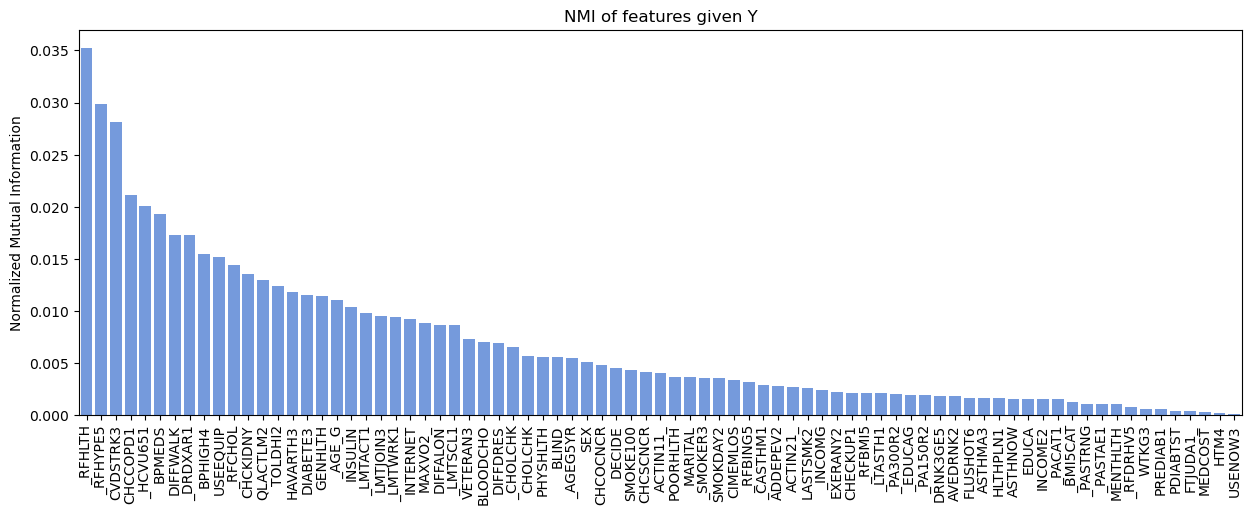

In [13]:
import seaborn as sns
# print the entropies with the corresponding feature
print(list(zip(all_features, NMI)))

# plot the NMI in seaborn in a bar plot (sorted by entropy)
# Sort the features by entropy
sorted_indices = np.argsort(NMI)[::-1]
sorted_features = [all_features[i] for i in sorted_indices]
sorted_entropies = [NMI[i] for i in sorted_indices]

# Plot the entropies
plt.figure(figsize=(15, 5))
sns.barplot(x=sorted_features, y=sorted_entropies,color='cornflowerblue')
plt.xticks(rotation=90)
plt.ylabel('Normalized Mutual Information')
plt.title('NMI of features given Y')
plt.show()

We observe from this that the most dependent features to the target are :
- _RFHLTH : Adults with good or better health
- _RFHYPE5 : Adults who have been told they have high blood pressure by a doctor, nurse, or other health professional
- CVDSTRK3 : "(Ever told) you had a stroke"
- CHCCOPD1 : "(Ever told) you have Chronic Obstructive Pulmonary Disease or COPD, emphysema or chronic bronchitis?"

Because our implementations are slow when using all the features, we will use only the most important features to train the model.

In [62]:
# keep features with NMI > 0.01
features_good_nmi = [feature for feature, nmi in zip(all_features, NMI) if nmi > 0.009]
print(f"Selected {len(features_good_nmi)} features out of {len(all_features)}")
print(features_good_nmi)

Selected 23 features out of 79
['GENHLTH', 'BPHIGH4', 'BPMEDS', 'TOLDHI2', 'CVDSTRK3', 'CHCCOPD1', 'HAVARTH3', 'CHCKIDNY', 'DIABETE3', 'INTERNET', 'QLACTLM2', 'USEEQUIP', 'DIFFWALK', 'LMTJOIN3', 'INSULIN', '_RFHLTH', '_HCVU651', '_RFHYPE5', '_RFCHOL', '_DRDXAR1', '_AGE_G', '_LMTACT1', '_LMTWRK1']


### 2.3.2 Point-Biserial Correlation 

Another way to evaluate the correlation between the  features and the binary target is to use Point-Biserial Correlation. It provides a linear correlation measure that is appropriate for our binary target variable. It should be noted that due to the categorical nature of the features, the correlation values might not be as informative as for continuous variables.

In [13]:
# Function to calculate the point-biserial correlation between a feature (x) and a binary target (y)
def point_biserial_correlation(x, y):
    # Calculate the mean of the feature values for y == 1
    y_mean_1 = np.mean(x[y == 1])
    
    # Calculate the mean of the feature values for y == -1
    y_mean_0 = np.mean(x[y == -1])
    
    # Calculate the standard deviation of the feature values
    y_std = np.std(x)
    
    # Calculate the proportion of samples in each class
    p = np.sum(y == 1) / len(y)
    q = 1 - p
    
    # Calculate the point-biserial correlation using the formula
    correlation = (y_mean_1 - y_mean_0) * np.sqrt(p * q) / y_std if y_std > 0 else 0
    
    return correlation

# Function to calculate the point-biserial correlation for each selected feature in the dataset
def calculate_correlations_point_biserial(x_train, y_train, selected_features):
    correlations = {}

    # Iterate through each feature and calculate its correlation with the target variable
    for idx, feature_name in enumerate(selected_features):
        # Extract the feature values for the current feature
        feature_values = x_train[:, idx]
        
        # Calculate the point-biserial correlation between the feature and target
        correlation = point_biserial_correlation(feature_values, y_train)
        
        # Store the correlation in the dictionary with the feature name as the key
        correlations[feature_name] = correlation

    # Print all correlations as a list
    correlation_list = [(feature, correlations[feature]) for feature in selected_features]
    print("\nList of features and their correlations:")
    for feature, corr in correlation_list:
        print(f"{feature}: {corr:.2f}")

    return correlations

# Run the code with your provided dataset and mappings
all_features = list(mapping_dict.keys())
x_train_filtered2 = apply_mapping(x_train, all_features, mapping_dict)

# Extract only the target variable from y_train to create a 1D array
if y_train.ndim > 1 and y_train.shape[1] > 1:
    y_train_target = y_train[:, 1] 
else:
    y_train_target = y_train 

# Ensure y_train_target is a 1D array with the correct length
y_train_target = y_train_target.flatten()

# Convert x_train_filtered to numpy array if needed
x_train_filtered_array = np.array(x_train_filtered2)

# Now run the point-biserial correlation calculations
correlations = calculate_correlations_point_biserial(x_train_filtered_array, y_train_target, all_features)



List of features and their correlations:
GENHLTH: 0.24
PHYSHLTH: -0.12
MENTHLTH: -0.02
POORHLTH: 0.01
HLTHPLN1: -0.03
MEDCOST: -0.01
CHECKUP1: -0.05
BPHIGH4: -0.20
BPMEDS: 0.19
BLOODCHO: -0.05
CHOLCHK: 0.00
TOLDHI2: 0.00
CVDSTRK3: -0.10
ASTHMA3: -0.03
ASTHNOW: 0.04
CHCSCNCR: -0.06
CHCOCNCR: -0.06
CHCCOPD1: -0.09
HAVARTH3: -0.12
ADDEPEV2: -0.04
CHCKIDNY: -0.05
DIABETE3: -0.16
SEX: -0.07
MARITAL: -0.03
EDUCA: -0.08
VETERAN3: -0.09
INCOME2: 0.00
INTERNET: 0.10
WTKG3: 0.06
QLACTLM2: -0.09
USEEQUIP: -0.09
BLIND: -0.02
DECIDE: -0.03
DIFFWALK: -0.10
DIFFDRES: -0.03
DIFFALON: -0.04
SMOKE100: -0.06
SMOKDAY2: 0.11
LASTSMK2: 0.08
USENOW3: 0.01
AVEDRNK2: -0.02
DRNK3GE5: -0.05
EXERANY2: 0.04
LMTJOIN3: 0.13
FLUSHOT6: -0.03
PDIABTST: -0.02
PREDIAB1: -0.02
INSULIN: 0.11
CIMEMLOS: 0.06
_RFHLTH: 0.17
_HCVU651: 0.20
_RFHYPE5: 0.17
_CHOLCHK: -0.05
_RFCHOL: 0.14
_LTASTH1: 0.04
_CASTHM1: 0.03
_DRDXAR1: -0.16
_AGEG5YR: 0.22
_AGE_G: 0.21
HTM4: 0.02
_RFBMI5: -0.02
_EDUCAG: -0.08
_SMOKER3: -0.05
_RFBING5: -0.0

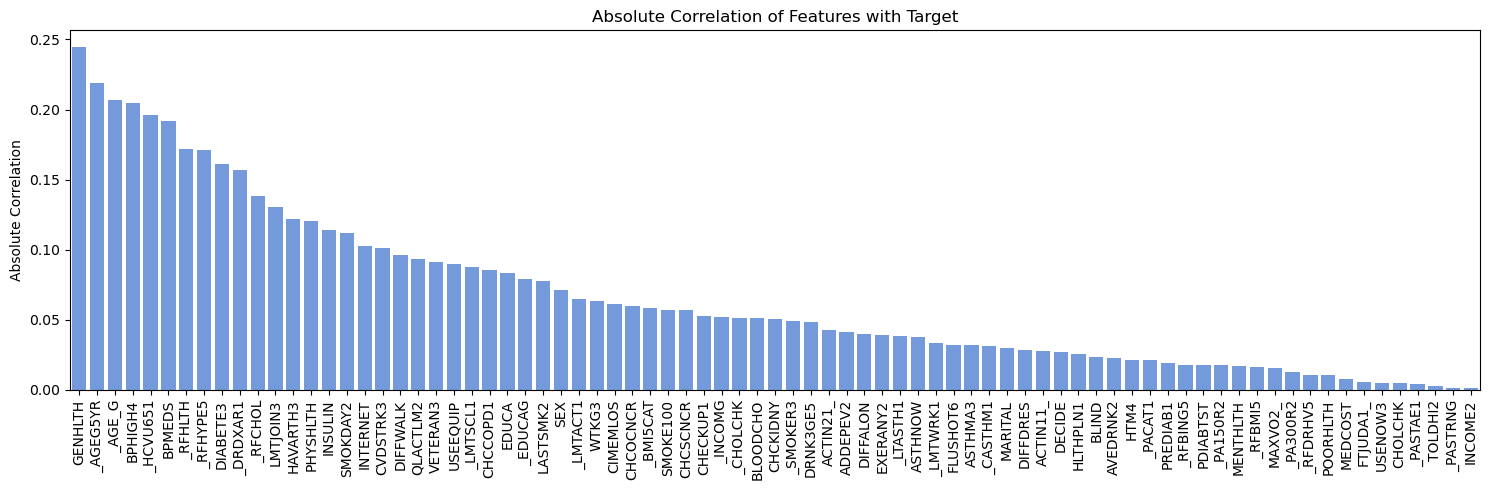

In [14]:
import seaborn as sns
# Calculate the absolute values of correlations
correlations_abs = {key: abs(value) for key, value in correlations.items()}

# Sort the correlations in descending order
sorted_correlations = dict(sorted(correlations_abs.items(), key=lambda item: item[1], reverse=True))

# Extract the feature names and their corresponding absolute correlations
the_features = list(sorted_correlations.keys())
correlation_values = list(sorted_correlations.values())

plt.figure(figsize=(15, 5))
sns.barplot(x=the_features, y=correlation_values, color='cornflowerblue')
plt.xticks(rotation=90)
plt.ylabel('Absolute Correlation')
plt.title('Absolute Correlation of Features with Target')
plt.tight_layout()
plt.show()


We observe from this that the most dependent features to the target are :
- GENHLTH : Would you say that in general your health is: 
- _AGEG5YR : Fourteen-level age category 
- _AGE_G : Six-level imputed age category 
- BPHIGH4 : Have you EVER been told by a doctor, nurse or other health professional that you have high blood pressure? 


In [15]:
# Only select the features with more than 0.1 for absolute value of correlation
threshold = 0.05
selected_features_biserial = [feature for feature, corr in correlations.items() if abs(corr) >= threshold]
print(f"Selected {len(selected_features_biserial)} features out of {len(all_features)}")
print(selected_features_biserial)

Selected 40 features out of 79
['GENHLTH', 'PHYSHLTH', 'CHECKUP1', 'BPHIGH4', 'BPMEDS', 'BLOODCHO', 'CVDSTRK3', 'CHCSCNCR', 'CHCOCNCR', 'CHCCOPD1', 'HAVARTH3', 'CHCKIDNY', 'DIABETE3', 'SEX', 'EDUCA', 'VETERAN3', 'INTERNET', 'WTKG3', 'QLACTLM2', 'USEEQUIP', 'DIFFWALK', 'SMOKE100', 'SMOKDAY2', 'LASTSMK2', 'LMTJOIN3', 'INSULIN', 'CIMEMLOS', '_RFHLTH', '_HCVU651', '_RFHYPE5', '_CHOLCHK', '_RFCHOL', '_DRDXAR1', '_AGEG5YR', '_AGE_G', '_EDUCAG', '_BMI5CAT', '_LMTACT1', '_LMTSCL1', '_INCOMG']


# 3. Train/Test Split

## 3.1 Cross-validation

In [10]:
def split_data_k_folds(x, y, n_folds=4):
    """
    Splits the dataset into k folds for cross-validation.
    Parameters:
    x (numpy.ndarray): The input features of the dataset.
    y (numpy.ndarray): The target labels of the dataset.
    n_folds (int, optional): The number of folds to split the data into. Default is 5.
    Returns:
    list of tuples: A list where each tuple contains four elements:
        - x_train (numpy.ndarray): Training set features for the current fold.
        - y_train (numpy.ndarray): Training set labels for the current fold.
        - x_test (numpy.ndarray): Test set features for the current fold.
        - y_test (numpy.ndarray): Test set labels for the current fold.
    """
    # Shuffle the data
    indices = np.random.permutation(x.shape[0])
    
    # Split indices into n equal-sized parts
    fold_sizes = np.full(n_folds, x.shape[0] // n_folds, dtype=int)  # Base size of each fold
    fold_sizes[:x.shape[0] % n_folds] += 1  # Distribute the remainder

    current = 0
    folds = []
    for fold_size in fold_sizes:
        start, stop = current, current + fold_size
        test_indices = indices[start:stop]  # Select current fold as test set
        train_indices = np.concatenate([indices[:start], indices[stop:]])  # Rest are training
        
        x_train, y_train = x[train_indices], y[train_indices]
        x_test, y_test = x[test_indices], y[test_indices]
        folds.append((x_train, y_train, x_test, y_test))
        
        current = stop

    return folds

# 5. Model Selection and Training

## 5.1 Implementing the models

We will implement and compare the following models:
- **Logistic Regression**
- **Categorical Naive Bayes Classifier**
- **Random Forest Classifier**

This is because they are relatively simple to implement, they can handle categorical data (except for Logistic Regression that will need one hot encoding), and they are suitable for binary classification tasks.

In [42]:

class LogisticRegression:
    def __init__(self, max_iters=300, gamma=0.2, lambda_= 0.001):
        self.max_iters = max_iters
        self.gamma = gamma
        self.lambda_ = lambda_
        self.w = None

    def fit(self, X, y):
        self.w, _ = reg_logistic_regression(y, X, self.lambda_, np.zeros(X.shape[1]), self.max_iters, self.gamma)

    def predict(self, X):
        return np.array([1 if p > 0.5 else 0 for p in sigmoid(X @ self.w)])
    
class CategoricalNaiveBayes:
    def __init__(self, smoothing=1e-6):
        self.class_probs = None
        self.feature_probs = None
        self.classes = None
        self.smoothing = smoothing  # Smoothing factor for Laplace smoothing

    def fit(self, X, y):
        # Get the unique classes and initialize dictionaries to store probabilities
        self.classes = np.unique(y)
        num_classes = len(self.classes)
        
        # Calculate class probabilities P(y)
        self.class_probs = np.array([(y == c).mean() for c in self.classes])

        # Calculate feature probabilities P(X|y) for each feature and class
        num_features = X.shape[1]
        self.feature_probs = {}

        for feature_idx in range(num_features):
            feature_values = np.unique(X[:, feature_idx])
            self.feature_probs[feature_idx] = {}
            
            for class_idx, class_value in enumerate(self.classes):
                self.feature_probs[feature_idx][class_value] = {}
                
                # Filter X by class to get only relevant rows
                X_class = X[y == class_value, feature_idx]
                
                for value in feature_values:
                    # Calculate P(feature=value | class) with smoothing
                    prob = ((X_class == value).sum() + self.smoothing) / (len(X_class) + len(feature_values) * self.smoothing)
                    self.feature_probs[feature_idx][class_value][value] = prob

    def predict(self, X):
        # Initialize predictions list
        predictions = []
        
        for row in X:
            # Calculate log-probabilities for each class
            class_log_probs = []
            
            for class_idx, class_value in enumerate(self.classes):
                # Start with log of the class probability
                log_prob = np.log(self.class_probs[class_idx])
                
                for feature_idx in range(len(row)):
                    feature_value = row[feature_idx]
                    # Get the feature probability P(X|y), apply smoothing if not present
                    feature_prob = self.feature_probs[feature_idx][class_value].get(feature_value, self.smoothing)
                    log_prob += np.log(feature_prob)
                
                class_log_probs.append(log_prob)
            
            # Predict the class with the highest log-probability
            predictions.append(self.classes[np.argmax(class_log_probs)])
        
        return np.array(predictions)
    
class RandomForest:
    class TreeNode:
        def __init__(self, feature_index=None, threshold=None, left=None, right=None, value=None):
            self.feature_index = feature_index
            self.threshold = threshold
            self.left = left
            self.right = right
            self.value = value

    class Tree:
        def __init__(self, max_depth=3, min_sample_split=2):
            self.max_depth = max_depth
            self.min_sample_split = min_sample_split
            self.root = None

        def fit(self, x, y, depth=0):
            if len(y) == 0:
                return None
            
            y = y.astype(int)

            if x.shape[0] < self.min_sample_split or len(set(y)) == 1 or depth >= self.max_depth:
                leaf_value = self._calculate_leaf_value(y)
                return RandomForest.TreeNode(value=leaf_value)

            best_feature, best_threshold = self._best_split(x, y)

            # Handle the case where no valid split is found
            if best_feature is None or best_threshold is None:
                leaf_value = self._calculate_leaf_value(y)
                return RandomForest.TreeNode(value=leaf_value)

            left_indices = x[:, best_feature] <= best_threshold
            right_indices = x[:, best_feature] > best_threshold

            left_subtree = self.fit(x[left_indices], y[left_indices], depth + 1)
            right_subtree = self.fit(x[right_indices], y[right_indices], depth + 1)

            return RandomForest.TreeNode(
                feature_index=best_feature,
                threshold=best_threshold,
                left=left_subtree,
                right=right_subtree
            )

        def predict(self, x):
            return self._traverse_tree(x, self.root)

        def _traverse_tree(self, x, tree_node):
            if tree_node.value is not None:
                return np.full((x.shape[0],), tree_node.value)

            # Go right or left
            left_indices = x[:, tree_node.feature_index] <= tree_node.threshold
            right_indices = x[:, tree_node.feature_index] > tree_node.threshold

            # Empty array for predictions
            predictions = np.empty(x.shape[0])

            # Predict for left and right subtree
            if np.any(left_indices):
                predictions[left_indices] = self._traverse_tree(x[left_indices], tree_node.left)
            if np.any(right_indices):
                predictions[right_indices] = self._traverse_tree(x[right_indices], tree_node.right)

            return predictions

        def _calculate_leaf_value(self, y):
            values, counts = np.unique(y, return_counts=True)
            return values[np.argmax(counts)]

        def _gini_impurity(self, y):
            D = len(y)
            _, count = np.unique(y, return_counts=True, axis=0)
            gini = 1 - np.sum((count / D) ** 2)
            return gini

        def _best_split(self, x, y):
            N, D = x.shape
            C = np.max(y) + 1  # Number of classes
            y_onehot = np.eye(C)[y]  # Shape (N, C)

            best_feature = None
            best_threshold = None
            best_gini_impurity = np.inf

            for i in range(D):
                xi = x[:, i]
                unique_values = np.unique(xi)

                if len(unique_values) == 1:
                    continue  # Cannot split on this feature

                thresholds = (unique_values[:-1] + unique_values[1:]) / 2  # Possible thresholds

                # Compute left masks for all thresholds
                left_masks = xi[np.newaxis, :] <= thresholds[:, np.newaxis]  # Shape (M, N)

                # Compute class counts for left and right branches
                counts_left = left_masks.dot(y_onehot)  # Shape (M, C)
                counts_left_total = counts_left.sum(axis=1)  # Shape (M,)
                counts_total = y_onehot.sum(axis=0)  # Shape (C,)
                counts_right = counts_total - counts_left  # Shape (M, C)
                counts_right_total = counts_right.sum(axis=1)  # Shape (M,)

                # Avoid division by zero
                valid_left = counts_left_total > 0
                valid_right = counts_right_total > 0

                # Calculate probabilities
                probs_left = np.zeros_like(counts_left)
                probs_right = np.zeros_like(counts_right)
                probs_left[valid_left] = counts_left[valid_left] / counts_left_total[valid_left, None]
                probs_right[valid_right] = counts_right[valid_right] / counts_right_total[valid_right, None]

                # Calculate Gini impurities
                gini_left = 1 - np.sum(probs_left**2, axis=1)
                gini_right = 1 - np.sum(probs_right**2, axis=1)
                gini_left[~valid_left] = 0  # No impurity if branch is empty
                gini_right[~valid_right] = 0

                # Weighted Gini impurity for all thresholds
                gini = (gini_left * counts_left_total + gini_right * counts_right_total) / N

                # Find the threshold with minimum Gini impurity
                min_gini_idx = np.argmin(gini)
                min_gini = gini[min_gini_idx]

                if min_gini < best_gini_impurity:
                    best_gini_impurity = min_gini
                    best_feature = i
                    best_threshold = thresholds[min_gini_idx]

            return best_feature, best_threshold

    def __init__(self, n_trees=20, max_depth=10, min_samples_split=2, seed=42):
        self.n_trees = n_trees
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.rng = np.random.default_rng(seed)
        self.list_tree = []

    def fit(self, x, y):
        # Create the trees
        self.list_tree = []
        for _ in range(self.n_trees):
            bootstrap_x, bootstrap_y = self._bootstrap_sample(x, y)
            tree = RandomForest.Tree(self.max_depth, self.min_samples_split)
            tree.root = tree.fit(bootstrap_x, bootstrap_y)
            self.list_tree.append(tree)

    def predict(self, x):
        n_trees = len(self.list_tree)
        predictions = np.zeros((len(x), n_trees))
        for i, tree in enumerate(self.list_tree):
            pred = tree.predict(x)
            #shift of ten to be positive
            predictions[:, i] = pred

        # Majority vote
        #Shift forth and back to ten to be positive
        predictions += 10
        dominant_prediction = np.apply_along_axis(lambda p: np.bincount(p.astype(int)).argmax(), axis=1, arr=predictions)
        dominant_prediction -= 10

        
        return dominant_prediction

    def _bootstrap_sample(self, x, y):
        N, _ = x.shape
        bootstrap_indices = self.rng.choice(N, N, replace=True)
        x_bootstrap = x[bootstrap_indices]
        y_bootstrap = y[bootstrap_indices]
        return x_bootstrap, y_bootstrap

## 5.2 Training and Comparing the Models

In [12]:
def accuracy_precision_recall_f1(y_true, y_pred):
    """
    Calculate accuracy, precision, recall, and F1 score for binary classification (y in {0,1}, 1 being positive).

    Parameters:
    y_true (array-like): True binary labels.
    y_pred (array-like): Predicted binary labels.

    Returns:
    tuple: A tuple containing:
        - accuracy (float): The accuracy of the predictions.
        - precision (float): The precision of the predictions.
        - recall (float): The recall of the predictions.
        - f1 (float): The F1 score of the predictions.
    """
    tp = np.sum((y_true == 1) & (y_pred == 1))
    fp = np.sum((y_true == 0) & (y_pred == 1))
    tn = np.sum((y_true == 0) & (y_pred == 0))
    fn = np.sum((y_true == 1) & (y_pred == 0))
    accuracy = (tp + tn) / len(y_true)
    precision = tp / (tp + fp) if tp + fp > 0 else 0
    recall = tp / (tp + fn) if tp + fn > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if precision + recall > 0 else 0
    return accuracy, precision, recall, f1

def cleaning_x_pipeline(x_train, y_train, x_test, features, nan_threshold=0.1, n_folds=4, dont_balance=False,oneHot=False):
    np.random.seed(41)

    selected_features = select_features_with_low_nan_ratio(x_train, features, threshold=nan_threshold)
    print("Features with low NaN ratio selected. Number of features:", len(selected_features))

    # cleaning
    x_train_filtered_mapped = apply_mapping(x_train, selected_features, mapping_dict)
    x_test_filtered_mapped = apply_mapping(x_test, selected_features, mapping_dict)
    print("Features mapped to categorical values.")

    if oneHot:
        # One-hot encoding
        combined = np.vstack((x_train_filtered_mapped, x_test_filtered_mapped))
        combined_encoded = one_hot_encode(combined, selected_features)
        x_train_encoded = combined_encoded[:len(x_train_filtered_mapped)]
        x_test_encoded = combined_encoded[len(x_train_filtered_mapped):]
        print("Features one-hot encoded.")
    else:
        # Label encoding
        # we need to combine the training and test set so that the encoding is the same for both
        combined = np.vstack((x_train_filtered_mapped, x_test_filtered_mapped))
        combined_encoded = label_encode(combined, selected_features)
        x_train_encoded = combined_encoded[:len(x_train_filtered_mapped)]
        x_test_encoded = combined_encoded[len(x_train_filtered_mapped):]
        print("Features label encoded.")

    # no splitting (for submission)
    if n_folds==0:
        # fix class imbalance in the training set
        x_train_encoded_fixed, y_train_fixed = fix_class_imbalance(x_train_encoded, y_train, target_value=1, dont_balance=dont_balance)
        print("Class imbalance fixed.")

        return x_train_encoded, x_train_encoded_fixed, y_train_fixed, x_test_encoded
    # splitting (for cross-validation)
    else:
        # split the data into k folds
        folds = split_data_k_folds(x_train_encoded, y_train, n_folds=n_folds)
        print("Data split into k folds.")
        balanced_folds = []

        for x_train_fold, y_train_fold, x_test_fold, y_test_fold in folds:
            # fix class imbalance in the training set
            x_train_fold_fixed, y_train_fold_fixed = fix_class_imbalance(x_train_fold, y_train_fold, target_value=1, dont_balance=dont_balance)
            balanced_folds.append((x_train_fold, x_train_fold_fixed, y_train_fold, y_train_fold_fixed, x_test_fold, y_test_fold))

        print("Class imbalance fixed.")

        return balanced_folds, x_test_encoded
    
def evaluate_model(x_train, y_train, x_test, final_features, nan_threshold=0.1, dont_balance=False, n_folds=4, model=CategoricalNaiveBayes(), oneHot=False):
    # process the data and split it into k folds
    y_train_mapped = map_y_to_0_1(y_train[:,1])
    balanced_folds, x_test_encoded = cleaning_x_pipeline(x_train, y_train_mapped, x_test, final_features, nan_threshold=nan_threshold, n_folds=n_folds, dont_balance=dont_balance, oneHot=oneHot)

    # Initialize array metrics of size n_folds*4
    metrics_train = np.zeros((n_folds, 4))
    metrics_train_fixed = np.zeros((n_folds, 4))
    metrics_test = np.zeros((n_folds, 4))

    for i in range(len(balanced_folds)):
        x_train_fold, x_train_fold_fixed, y_train_fold, y_train_fold_fixed, x_test_fold, y_test_fold = balanced_folds[i]
        model.fit(x_train_fold_fixed, y_train_fold_fixed)

        # Predict on the train, train_fixed and test set
        y_train_pred = model.predict(x_train_fold)
        y_train_fixed_pred = model.predict(x_train_fold_fixed)
        y_test_pred = model.predict(x_test_fold)

        # Calculate the accuracy, precision, recall and F1 score
        metrics_train[i] = accuracy_precision_recall_f1(y_train_fold, y_train_pred)
        metrics_train_fixed[i] = accuracy_precision_recall_f1(y_train_fold_fixed, y_train_fixed_pred)
        metrics_test[i] = accuracy_precision_recall_f1(y_test_fold, y_test_pred)

        print(f"Fold {i+1} completed.")

    # take the average
    metrics_train = np.mean(metrics_train, axis=0) # scores on the original trains and
    metrics_train_fixed = np.mean(metrics_train_fixed, axis=0) # scores on the train set with class imbalance fixed
    metrics_test = np.mean(metrics_test, axis=0) # scores on the test set

    return metrics_train, metrics_train_fixed, metrics_test

* **Training with the NMI approach for selecting features**

In [19]:
# Categorical Naive Bayes 
final_features = features_good_nmi
metrics_train_LR, metrics_train_fixed_LR, metrics_test_LR = evaluate_model(x_train, y_train, x_test, final_features, nan_threshold=0.1, dont_balance=False, n_folds=4, model=CategoricalNaiveBayes(), oneHot=False)
print("Categorical Naive Bayes")
print(f"Train set: Accuracy={metrics_train_LR[0]:.2f}, Precision={metrics_train_LR[1]:.2f}, Recall={metrics_train_LR[2]:.2f}, F1={metrics_train_LR[3]:.5f}")
print(f"Train set fixed: Accuracy={metrics_train_fixed_LR[0]:.2f}, Precision={metrics_train_fixed_LR[1]:.2f}, Recall={metrics_train_fixed_LR[2]:.2f}, F1={metrics_train_fixed_LR[3]:.5f}")
print(f"Test set: Accuracy={metrics_test_LR[0]:.2f}, Precision={metrics_test_LR[1]:.2f}, Recall={metrics_test_LR[2]:.2f}, F1={metrics_test_LR[3]:.5f}")

Features with low NaN ratio selected. Number of features: 18
Features mapped to categorical values.
Features label encoded.
Data split into k folds.
Class imbalance fixed.
Fold 1 completed.
Fold 2 completed.
Fold 3 completed.
Fold 4 completed.
Categorical Naive Bayes
Train set: Accuracy=0.74, Precision=0.21, Recall=0.73, F1=0.32829
Train set fixed: Accuracy=0.73, Precision=0.74, Recall=0.73, F1=0.73052
Test set: Accuracy=0.74, Precision=0.21, Recall=0.73, F1=0.32818


In [20]:
# Logistic Regression
all_features = features_good_nmi
metrics_train_LR, metrics_train_fixed_LR, metrics_test_LR = evaluate_model(x_train, y_train, x_test, all_features, nan_threshold=0.1, dont_balance=False, n_folds=4, model=LogisticRegression(), oneHot=True)
print("Logistic Regression")
print(f"Train set: Accuracy={metrics_train_LR[0]:.2f}, Precision={metrics_train_LR[1]:.2f}, Recall={metrics_train_LR[2]:.2f}, F1={metrics_train_LR[3]:.5f}")
print(f"Train set fixed: Accuracy={metrics_train_fixed_LR[0]:.2f}, Precision={metrics_train_fixed_LR[1]:.2f}, Recall={metrics_train_fixed_LR[2]:.2f}, F1={metrics_train_fixed_LR[3]:.5f}")
print(f"Test set: Accuracy={metrics_test_LR[0]:.2f}, Precision={metrics_test_LR[1]:.2f}, Recall={metrics_test_LR[2]:.2f}, F1={metrics_test_LR[3]:.5f}")

Features with low NaN ratio selected. Number of features: 18
Features mapped to categorical values.
Features one-hot encoded.
Data split into k folds.
Class imbalance fixed.
Fold 1 completed.
Fold 2 completed.
Fold 3 completed.
Fold 4 completed.
Logistic Regression
Train set: Accuracy=0.74, Precision=0.22, Recall=0.77, F1=0.34639
Train set fixed: Accuracy=0.76, Precision=0.75, Recall=0.77, F1=0.75881
Test set: Accuracy=0.74, Precision=0.22, Recall=0.77, F1=0.34622


* **Training with the Point Biserial approach for selecting features**

In [25]:
# Categorical Naive Bayes 
final_features = selected_features_biserial
metrics_train_LR, metrics_train_fixed_LR, metrics_test_LR = evaluate_model(x_train, y_train, x_test, final_features, nan_threshold=0.1, dont_balance=False, n_folds=4, model=CategoricalNaiveBayes(), oneHot=False)
print("Categorical Naive Bayes")
print(f"Train set: Accuracy={metrics_train_LR[0]:.2f}, Precision={metrics_train_LR[1]:.2f}, Recall={metrics_train_LR[2]:.2f}, F1={metrics_train_LR[3]:.5f}")
print(f"Train set fixed: Accuracy={metrics_train_fixed_LR[0]:.2f}, Precision={metrics_train_fixed_LR[1]:.2f}, Recall={metrics_train_fixed_LR[2]:.2f}, F1={metrics_train_fixed_LR[3]:.5f}")
print(f"Test set: Accuracy={metrics_test_LR[0]:.2f}, Precision={metrics_test_LR[1]:.2f}, Recall={metrics_test_LR[2]:.2f}, F1={metrics_test_LR[3]:.5f}")

Features with low NaN ratio selected. Number of features: 33
Features mapped to categorical values.
Features label encoded.
Data split into k folds.
Class imbalance fixed.
Fold 1 completed.
Fold 2 completed.
Fold 3 completed.
Fold 4 completed.
Categorical Naive Bayes
Train set: Accuracy=0.74, Precision=0.22, Recall=0.76, F1=0.33813
Train set fixed: Accuracy=0.75, Precision=0.74, Recall=0.76, F1=0.75052
Test set: Accuracy=0.74, Precision=0.22, Recall=0.76, F1=0.33801


In [26]:
# Logistic Regression
all_features = selected_features_biserial
metrics_train_LR, metrics_train_fixed_LR, metrics_test_LR = evaluate_model(x_train, y_train, x_test, all_features, nan_threshold=0.1, dont_balance=False, n_folds=4, model=LogisticRegression(), oneHot=True)
print("Logistic Regression")
print(f"Train set: Accuracy={metrics_train_LR[0]:.2f}, Precision={metrics_train_LR[1]:.2f}, Recall={metrics_train_LR[2]:.2f}, F1={metrics_train_LR[3]:.5f}")
print(f"Train set fixed: Accuracy={metrics_train_fixed_LR[0]:.2f}, Precision={metrics_train_fixed_LR[1]:.2f}, Recall={metrics_train_fixed_LR[2]:.2f}, F1={metrics_train_fixed_LR[3]:.5f}")
print(f"Test set: Accuracy={metrics_test_LR[0]:.2f}, Precision={metrics_test_LR[1]:.2f}, Recall={metrics_test_LR[2]:.2f}, F1={metrics_test_LR[3]:.5f}")

Features with low NaN ratio selected. Number of features: 33
Features mapped to categorical values.
Features one-hot encoded.
Data split into k folds.
Class imbalance fixed.
Regularized Logistic Regression(0/299): loss=0.6931471805599448, w0=-4.4537875008907573e-07, w1=-0.007241635787073328
Regularized Logistic Regression(1/299): loss=0.6593737379366176, w0=-8.645660312239105e-07, w1=-0.013502058451690052
Regularized Logistic Regression(2/299): loss=0.6334547031332458, w0=-1.2695425683827828e-06, w1=-0.01916872181250339
Regularized Logistic Regression(3/299): loss=0.6130468239574801, w0=-1.6631941864433238e-06, w1=-0.02436375393910451
Regularized Logistic Regression(4/299): loss=0.5967971887319766, w0=-2.04686256958184e-06, w1=-0.029159415443309192
Regularized Logistic Regression(5/299): loss=0.5837046695424597, w0=-2.421532770954573e-06, w1=-0.03361211142283319
Regularized Logistic Regression(6/299): loss=0.5730271688348431, w0=-2.788029654153424e-06, w1=-0.03776854126965966
Regulariz

In [29]:
# Random Forest
# all_features = features_good_nmi
all_features = ['_RFHLTH', 'MAXVO2_', 'GENHLTH', 'CVDSTRK3', 'BLOODCHO', 'SEX', 'HLTHPLN1']
model = RandomForest(n_trees=50, max_depth=10, min_samples_split=10)
metrics_train_LR, metrics_train_fixed_LR, metrics_test_LR = evaluate_model(x_train, y_train, x_test, all_features, nan_threshold=0.1, dont_balance=False, n_folds=4, model=model, oneHot=False)
print("Logistic Regression")
print(f"Train set: Accuracy={metrics_train_LR[0]:.2f}, Precision={metrics_train_LR[1]:.2f}, Recall={metrics_train_LR[2]:.2f}, F1={metrics_train_LR[3]:.5f}")
print(f"Train set fixed: Accuracy={metrics_train_fixed_LR[0]:.2f}, Precision={metrics_train_fixed_LR[1]:.2f}, Recall={metrics_train_fixed_LR[2]:.2f}, F1={metrics_train_fixed_LR[3]:.5f}")
print(f"Test set: Accuracy={metrics_test_LR[0]:.2f}, Precision={metrics_test_LR[1]:.2f}, Recall={metrics_test_LR[2]:.2f}, F1={metrics_test_LR[3]:.5f}")

Features with low NaN ratio selected. Number of features: 7
Features mapped to categorical values.
Features label encoded.
Data split into k folds.
Class imbalance fixed.
Fold 1 completed.
Fold 2 completed.
Fold 3 completed.
Fold 4 completed.
Logistic Regression
Train set: Accuracy=0.72, Precision=0.21, Recall=0.81, F1=0.33876
Train set fixed: Accuracy=0.76, Precision=0.74, Recall=0.81, F1=0.77388
Test set: Accuracy=0.72, Precision=0.21, Recall=0.80, F1=0.33535


# 6. Model Optimization

## 6.1 Greedy approach to select features

Simply choosing the best features according to mutual information can lead to suboptimal performance because the features may be for example strongly correlated. A better approach is to select greedily the best features one by one ideally from all available features until the F1-score decreases. However, this approach is computationally expensive so we will only run it on a subset of the instances (1%)

In [43]:
def greedy_feature_selection(x_train, y_train, x_test, start_features, features, dont_balance=False, model=CategoricalNaiveBayes(), oneHot=False):
    features = select_features_with_low_nan_ratio(x_train, features, threshold=1)
    # remove the start_features from the features
    for feature in start_features:
        features.remove(feature)
    n_features = len(features)
    selected_features = start_features
    remaining_features = features.copy()

    best_f1 = 0
    while remaining_features:
        # Track the best feature and F1 score in the current iteration
        best_feature = None
        best_f1_iteration = 0
        # print(remaining_features)
        # Try adding each remaining feature and evaluate F1 score
        for feature in remaining_features:
            current_features = selected_features + [feature]  # Add feature to the selected set
            # print(current_features)

            metrics_train, metrics_train_fixed, metrics_test = evaluate_model(x_train, y_train, x_test, current_features, nan_threshold=1, dont_balance=dont_balance, n_folds=4, model=model, oneHot=oneHot)
            f1_test = metrics_test[3]
            print(f"Feature: {current_features}, F1: {f1_test}")
            print(metrics_train, metrics_train_fixed, metrics_test)

            # Check if the current F1 score is the best so far
            if f1_test > best_f1_iteration:
                best_f1_iteration = f1_test
                best_feature = feature
        # Stop if no improvement is made
        if best_f1_iteration <= best_f1:
            break
        
        # Update selected features and remaining features
        selected_features.append(best_feature)
        remaining_features.remove(best_feature)
        best_f1 = best_f1_iteration
        print(f"Best F1 score: {best_f1}")
        print(f"Selected features: {selected_features}")
        
    return selected_features, best_f1

In [44]:
# take a random subset of the instances of x_train and y_train
proportion = 0.01
n_instances = int(proportion * len(x_train))
indices = np.random.choice(len(x_train), n_instances, replace=False)
x_train_subset = x_train[indices]
y_train_subset = y_train[indices]
# print(indices)
print(f"Subset of {n_instances} instances taken from the training set.")

Subset of 3281 instances taken from the training set.


In [ ]:
# apply the greedy feature selection on all the features (with no pre-selection)
g_features = list(mapping_dict.keys())
# features =features_good_nmi
model = LogisticRegression()
# model = CategoricalNaiveBayes()
oneHot = True
start_features = []
selected_features, best_f1 = greedy_feature_selection(x_train_subset, y_train_subset, x_test, start_features, g_features, dont_balance=False, model=model, oneHot=oneHot)
# We drop the output of the greedy feature selection as it is too long

In [50]:
print(f"Selected features: {selected_features}")
print(f"Best F1 score (on the smaller train set): {best_f1}")

Selected features: ['GENHLTH', 'CVDSTRK3', '_CHOLCHK', 'CHECKUP1', 'CHCKIDNY', 'BLIND', 'MEDCOST']
Best F1 score: 0.36457489063533605


In [52]:
# evaluate the model with the selected features on the full training set
metrics_train, metrics_train_fixed, metrics_test = evaluate_model(x_train, y_train, x_test, selected_features, nan_threshold=1, dont_balance=False, n_folds=4, model=model, oneHot=oneHot)

Features with low NaN ratio selected. Number of features: 7
Features mapped to categorical values.
Features one-hot encoded.
Data split into k folds.
Class imbalance fixed.
Fold 1 completed.
Fold 2 completed.
Fold 3 completed.
Fold 4 completed.


In [53]:
print(f"Train set: Accuracy={metrics_train[0]:.2f}, Precision={metrics_train[1]:.2f}, Recall={metrics_train[2]:.2f}, F1={metrics_train[3]:.5f}")
print(f"Train set fixed: Accuracy={metrics_train_fixed[0]:.2f}, Precision={metrics_train_fixed[1]:.2f}, Recall={metrics_train_fixed[2]:.2f}, F1={metrics_train_fixed[3]:.5f}")
print(f"Test set: Accuracy={metrics_test[0]:.2f}, Precision={metrics_test[1]:.2f}, Recall={metrics_test[2]:.2f}, F1={metrics_test[3]:.5f}")

Train set: Accuracy=0.66, Precision=0.17, Recall=0.77, F1=0.28333
Train set fixed: Accuracy=0.71, Precision=0.68, Recall=0.77, F1=0.72385
Test set: Accuracy=0.66, Precision=0.17, Recall=0.77, F1=0.28337


The results are a lot worse than the previous ones, probably because we are using a small subset of the data which led to overfitting and a bad selection of features. The approach would however likely have worked with the full dataset.

## 6.2 Hyperparameter Tuning

To further optimize the model, we will perform hyperparameter tuning using grid search with cross-validation. This technique will help us identify the best combination of hyperparameters for a given model, improving its performance and generalization. This is also computationally expensive so we will only run it for the best model and on two sets of hyperparameters.

In [51]:
def hyperparameter_tuning(x_train, y_train, x_test, features, model_name, hyperparameters, dont_balance=False, one_hot=False):
    best_hyperparameters = None
    best_f1 = 0

    for hyperparameter in hyperparameters:
        model = globals().get(model_name)(**hyperparameter)
        print(f"Hyperparameter: {hyperparameter}")
        metrics_train, metrics_train_fixed, metrics_test = evaluate_model(x_train, y_train, x_test, features, nan_threshold=0.1, dont_balance=dont_balance, n_folds=4, model=model, oneHot=one_hot)
        f1 = metrics_test[3]

        if f1 > best_f1:
            best_f1 = f1
            best_hyperparameters = hyperparameter

    return best_hyperparameters, best_f1

In [60]:
model_name = "LogisticRegression"
hyperparameters = [
    {"max_iters": 300, "gamma": 0.2, "lambda_": 0.001},
    {"max_iters": 300, "gamma": 0.2, "lambda_": 0.005},
    {"max_iters": 300, "gamma": 0.4, "lambda_": 0.01},
]

best_hyperparameters, best_f1 = hyperparameter_tuning(
    x_train, y_train, x_test, features_good_nmi,
    model_name=model_name,
    hyperparameters=hyperparameters,
    dont_balance=False,
    one_hot=True
)

print(f"Best hyperparameters: {best_hyperparameters}")
print(f"Best F1 score: {best_f1}")
# took 35 minutes to run

Hyperparameter: {'max_iters': 300, 'gamma': 0.2, 'lambda_': 0.001}
Features with low NaN ratio selected. Number of features: 18
Features mapped to categorical values.
Features one-hot encoded.
Data split into k folds.
Class imbalance fixed.
Fold 1 completed.
Fold 2 completed.
Fold 3 completed.
Fold 4 completed.
Hyperparameter: {'max_iters': 300, 'gamma': 0.2, 'lambda_': 0.005}
Features with low NaN ratio selected. Number of features: 18
Features mapped to categorical values.
Features one-hot encoded.
Data split into k folds.
Class imbalance fixed.
Fold 1 completed.
Fold 2 completed.
Fold 3 completed.
Fold 4 completed.
Hyperparameter: {'max_iters': 300, 'gamma': 0.4, 'lambda_': 0.01}
Features with low NaN ratio selected. Number of features: 18
Features mapped to categorical values.
Features one-hot encoded.
Data split into k folds.
Class imbalance fixed.
Fold 1 completed.
Fold 2 completed.
Fold 3 completed.
Fold 4 completed.
Best hyperparameters: {'max_iters': 300, 'gamma': 0.2, 'lambda

# 7. Submission

In [61]:
# Adjusted `fit_predict_model()` function
def fit_predict_model(x_train, y_train, x_test, final_features, dont_balance=False, model=LogisticRegression(), oneHot=True):
    y_train_mapped = map_y_to_0_1(y_train[:, 1])
    pipeline_output = cleaning_x_pipeline(x_train, y_train_mapped, x_test, final_features, nan_threshold=0.1, n_folds=0, dont_balance=dont_balance, oneHot=oneHot)

    if len(pipeline_output) == 2:
        # Scenario with cross-validation (k-folds)
        folds, x_test_encoded = pipeline_output
        all_y_preds = []

        for x_train_fold, x_train_fold_fixed, y_train_fold, y_train_fold_fixed, x_test_fold, y_test_fold in folds:
            model.fit(x_train_fold_fixed, y_train_fold_fixed)
            y_pred_fold = model.predict(x_test_fold)
            y_train_pred_fold = model.predict(x_train_fold)

            # Store metrics for each fold if needed
            accuracy, precision, recall, f1 = accuracy_precision_recall_f1(y_train_fold, y_train_pred_fold)
            print(f"Fold training set: accuracy={accuracy:.2f}, precision={precision:.2f}, recall={recall:.2f}, F1={f1:.5f}")
            
            # Append all predictions for concatenation
            all_y_preds.extend(y_pred_fold)

        # Convert list of predictions to a numpy array
        y_pred = np.array(all_y_preds)
    else:
        # Scenario with no cross-validation (submission mode)
        x_train_encoded, x_train_encoded_fixed, y_train_fixed, x_test_encoded = pipeline_output
        model.fit(x_train_encoded_fixed, y_train_fixed)
        y_pred = model.predict(x_test_encoded)
        y_train_pred = model.predict(x_train_encoded)

        # Print metrics for the training set
        accuracy, precision, recall, f1 = accuracy_precision_recall_f1(y_train_mapped, y_train_pred)
        print(f"Training set: accuracy={accuracy:.2f}, precision={precision:.2f}, recall={recall:.2f}, F1={f1:.5f}")

    return y_pred


In [49]:
final_features = selected_features_biserial
y_pred_test = fit_predict_model(x_train, y_train, x_test, final_features, dont_balance=False, model=LogisticRegression(), oneHot=True)

Features with low NaN ratio selected. Number of features: 33
Features mapped to categorical values.
Features one-hot encoded.
Class imbalance fixed.
Regularized Logistic Regression(0/299): loss=0.6931471805599455, w0=-3.3426928733787943e-07, w1=-0.007326681374515309
Regularized Logistic Regression(1/299): loss=0.6593404237536585, w0=-6.488203768318196e-07, w1=-0.0136740136912758
Regularized Logistic Regression(2/299): loss=0.6334206692629297, w0=-9.526858640578429e-07, w1=-0.019429306855214205
Regularized Logistic Regression(3/299): loss=0.6130281652223516, w0=-1.2480432381127683e-06, w1=-0.024714556448944804
Regularized Logistic Regression(4/299): loss=0.5968025158677305, w0=-1.5359048328044015e-06, w1=-0.02960186300910172
Regularized Logistic Regression(5/299): loss=0.5837380434612482, w0=-1.8170134899426567e-06, w1=-0.034147468196289825
Regularized Logistic Regression(6/299): loss=0.5730899359412049, w0=-2.091990916310297e-06, w1=-0.038397915060808335
Regularized Logistic Regression

In [52]:
Ids = x_test[:,0]
y_pred_test_final = map_y_to_minus_1_1(y_pred_test)

np.savetxt("final_submission.csv", np.array([Ids, y_pred_test_final]).T, delimiter=",", fmt="%d", header="Id,Prediction", comments="")